<!-- # Analysis and Design of Multi-Layer Neural Networks (MLP)

## Table of Contents
- [MLP Design](#mlp-design)
- [Train Two Different Models](#train-two-different-models)
- [Back Propagation Algorithm](#back-propagation-algorithm)
- [Analysis of Different Hyperparameters](#analysis-of-different-hyperparameters)
- [References](#references) -->

## Import Libraries

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

## Utils

In [59]:
def plot_weight_histogram(model, layer_name, title='Weight Histogram'):
    plt.figure(figsize=(5, 3))
    weights = getattr(model, layer_name).weight.detach().cpu().numpy().flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(title)
    plt.xlabel("Weight")
    plt.ylabel("Frequency")
    plt.show()

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

np.random.seed(42)
torch.manual_seed(42)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cuda


In [61]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

one issue was I tried to set the transformer this lambda bellow and the test loss was unbelievable!

## Dataset

In [62]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] 
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

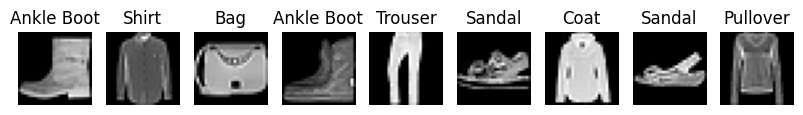

In [63]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 9,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## MLP Design

In [7]:
class Model(nn.Module):
    def __init__(self, h1, do_rate=0, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        # x = self.flatten(x)
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [48]:
def plot_curve(epochs, data, p_label, title, y_label):
    plt.plot(epochs, data, 'bo-', label=p_label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()

def plot_train_results(m):
    train_losses = m.train_losses
    train_accuracies = m.train_accuracies
    num_epochs = len(train_losses)
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plot_curve(epochs, train_losses, 'Training Loss', title='Training Loss', y_label='Loss')

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plot_curve(epochs, train_accuracies, 'Training Accuracy', title='Training Accuracy', y_label='Accuracy')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    return cm

In [32]:
class MLP():
    def __init__(self, model, criteria, lambda_reg=0, learning_rate=0.001):
        self.model = model
        self.criteria = criteria
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.optimizer = None 
        self.train_losses, self.train_accuracies = [], []

    def forward(self, images, labels):
        # Forward pass
        outputs = self.model(images)
        loss = self.criteria(outputs, labels)
        return outputs, loss

    def apply_l2_regularization(self):
        l2_reg = 0
        for param in self.model.parameters():
            l2_reg += torch.sum(param ** 2)
        return self.lambda_reg * l2_reg

    def evaluate(self, loader):
        self.model.to(device)
        self.model.eval()
        self.all_preds = []
        self.all_labels = []
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs, loss = self.forward(images, labels)
                loss += self.apply_l2_regularization()

                running_loss += loss.item() * images.size(0)  # is the batch size
                _, predicted = torch.max(outputs, dim=1)
                self.all_preds.extend(predicted.cpu().detach().numpy())
                self.all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(self.all_labels, self.all_preds)

    def train_with_optimizer(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # Reset gradients
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc
    
    def train(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc

    def test(self, loader):
        return self.evaluate(loader)
    
    def compile(self, optimizer, train_loader, test_loader, num_epochs):
        self.optimizer = optimizer(self.model.parameters(), self.learning_rate) # optim.SGD(self.model.parameters(), lr=self.learning_rate)
        train_hist, test_hist = [], []
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_with_optimizer(train_loader)
            train_hist.append({"epoch": epoch, "train_loss": train_loss, "train_acc": train_acc})

        test_loss, test_acc = self.evaluate(test_loader)
        test_hist.append({"test_loss": test_loss, "test_acc": test_acc})
        return train_hist, test_hist


In [ ]:
m = MLP(Model(100, do_rate=0.3), nn.CrossEntropyLoss())

In [11]:
num_epochs = 30

for epoch in range(num_epochs):
    train_loss, train_acc = m.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/30], Train Loss: 1.4353, Train Acc: 0.5700
Epoch [2/30], Train Loss: 0.8724, Train Acc: 0.7091
Epoch [3/30], Train Loss: 0.7503, Train Acc: 0.7376
Epoch [4/30], Train Loss: 0.6888, Train Acc: 0.7596
Epoch [5/30], Train Loss: 0.6498, Train Acc: 0.7702
Epoch [6/30], Train Loss: 0.6222, Train Acc: 0.7815
Epoch [7/30], Train Loss: 0.5986, Train Acc: 0.7895
Epoch [8/30], Train Loss: 0.5814, Train Acc: 0.7963
Epoch [9/30], Train Loss: 0.5660, Train Acc: 0.8024
Epoch [10/30], Train Loss: 0.5540, Train Acc: 0.8058
Epoch [11/30], Train Loss: 0.5425, Train Acc: 0.8107
Epoch [12/30], Train Loss: 0.5317, Train Acc: 0.8131
Epoch [13/30], Train Loss: 0.5238, Train Acc: 0.8159
Epoch [14/30], Train Loss: 0.5144, Train Acc: 0.8195
Epoch [15/30], Train Loss: 0.5066, Train Acc: 0.8234
Epoch [16/30], Train Loss: 0.5009, Train Acc: 0.8249
Epoch [17/30], Train Loss: 0.4959, Train Acc: 0.8250
Epoch [18/30], Train Loss: 0.4886, Train Acc: 0.8290
Epoch [19/30], Train Loss: 0.4832, Train Acc: 0.8307
Ep

In [52]:
plot_train_results(m)

AttributeError: 'int' object has no attribute 'train_losses'

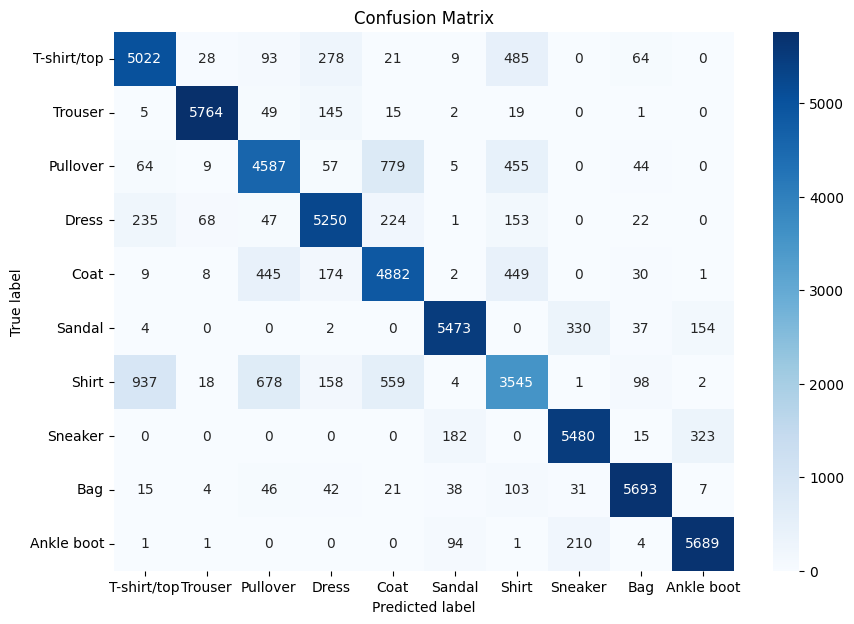

In [14]:
cm = plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [15]:
test_loss, _ = m.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m.all_labels, m.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4389
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.81      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.74      0.74      0.74      1000
       Dress       0.83      0.86      0.85      1000
        Coat       0.73      0.77      0.75      1000
      Sandal       0.94      0.89      0.91      1000
       Shirt       0.64      0.57      0.60      1000
     Sneaker       0.89      0.91      0.90      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.91      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



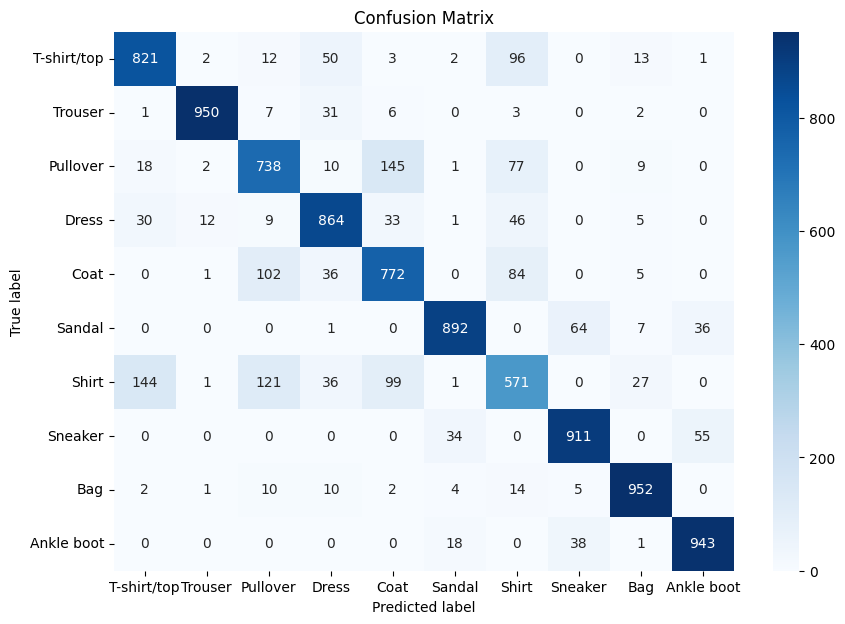

In [16]:
cm = plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [17]:
most_confused = {}
for i in range(10):
    row = cm[i]
    row[i] = 0
    most_confused_class = np.argmax(row)
    most_confused[i] = most_confused_class

for m in range(10):
    print(f"Class `{class_names[m]}` is most often confused with class `{class_names[most_confused[m]]}`")

Class `T-shirt/top` is most often confused with class `Shirt`
Class `Trouser` is most often confused with class `Dress`
Class `Pullover` is most often confused with class `Coat`
Class `Dress` is most often confused with class `Shirt`
Class `Coat` is most often confused with class `Pullover`
Class `Sandal` is most often confused with class `Sneaker`
Class `Shirt` is most often confused with class `T-shirt/top`
Class `Sneaker` is most often confused with class `Ankle boot`
Class `Bag` is most often confused with class `Shirt`
Class `Ankle boot` is most often confused with class `Sneaker`


In [18]:
conf_matrix_copy = cm.copy()
np.fill_diagonal(conf_matrix_copy, 0)  # Zero the diagonal

most_common_confusion = np.unravel_index(np.argmax(conf_matrix_copy), conf_matrix_copy.shape)

# Print the most commonly confused classes
print(f"The two most commonly confused classes are: `{class_names[most_common_confusion[0]]}` with `{class_names[most_common_confusion[1]]}`.")


The two most commonly confused classes are: `Pullover` with `Coat`.


#### Impact of Increasing Model Complexity

#### Criteria for Choosing the Best Configuration

- **Validation performance** : Monitor the validation accuracy and loss to ensure the model generalizes well.
- **Training stability** : Ensure that the model does not exhibit overfitting (training accuracy much higher than validation accuracy) or underfitting (both training and validation accuracies are low).
- **Computational efficiency** : Balance model complexity with computational resources (training time, memory usage).
- **Regularization** : Ensure proper regularization (e.g., dropout, L2 regularization) to prevent overfitting.

We can tune hyperparameters such as the number of layers, number of neurons per layer, regularization techniques, and learning rate to find the best configuration.

## Train Two Different Models

In [ ]:
# cirteria = nn.CrossEntropyLoss()

# train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
# model1 = Model(128)
# model1.parameters

In [ ]:
# model2 = Model(48, 0.2)
# model2.parameters

In [ ]:
# m1 = MLP(model1, cirteria)
# m2 = MLP(model2, cirteria, lambda_reg=0.0001)

In [ ]:
# num_epochs = 40

# for epoch in range(num_epochs):
#     train_loss, train_acc = m1.train(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
# print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

In [ ]:
# num_epochs = 40

# for epoch in range(num_epochs):
#     train_loss, train_acc = m2.train(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
# print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

In [ ]:
# test_loss, _ = m1.test(test_loader)
# print(f"Test Loss: {test_loss:.4f}")
# print(classification_report(m1.all_labels, m1.all_preds, target_names=class_names, zero_division=0))

In [ ]:
# test_loss, _ = m2.test(test_loader)
# print(f"Test Loss: {test_loss:.4f}")
# print(classification_report(m2.all_labels, m2.all_preds, target_names=class_names, zero_division=0))

In [ ]:
# weights = getattr(m1.model, 'out').weight.detach().cpu().numpy().flatten()

In [ ]:
# print("Model 1 Weight Histograms (128 Neurons, No Dropout)")
# plot_weight_histogram(m1.model, 'fc1', 'Model 1 Weight Histogram (Input-to-Hidden Layer)')
# plot_weight_histogram(m1.model, 'out', 'Model 1 Weight Histogram (Hidden-to-Output Layer)')

In [ ]:
# print("Model 2 Weight Histograms (48 Neurons, 20% Dropout, L2 Regularization)")
# plot_weight_histogram(m2.model, 'fc1', 'Model 2 Weight Histogram (Input-to-Hidden Layer)')
# plot_weight_histogram(m2.model, 'out', 'Model 2 Weight Histogram (Hidden-to-Output Layer)')

In [ ]:
# # Function to plot histograms for weights
# def plot_histogram(model, layer_index):
#     weights, biases = model.layers[layer_index].get_weights()
#     plt.figure(figsize=(5, 3))
#     plt.hist(weights.flatten(), bins=30)
#     layer_name = model.layers[layer_index].name
#     plt.title(f'Histogram of {layer_name} Layer Weights')
#     plt.show()

In [ ]:
# weights, biases = model1.layers[1].get_weights()
# print(model1.layers[1].name)
# weights, biases = model1.layers[2].get_weights()
# print(model1.layers[2].name)
# len(model1.layers)

In [ ]:
# weights, biases = model2.layers[1].get_weights()
# print(model2.layers[1].name)
# weights, biases = model2.layers[3].get_weights()
# print(model2.layers[3].name)
# len(model2.layers)

In [ ]:
# plot_histogram(model1, 1)
# plot_histogram(model1, 2)

In [ ]:
# plot_histogram(model2, 1)
# plot_histogram(model2, 3)

In [ ]:
# # Evaluate models on test data
# test_loss1, test_acc1 = model1.evaluate(x_test, y_test)
# test_loss2, test_acc2 = model2.evaluate(x_test, y_test)

# print(f"Model 1 Test Accuracy: {test_acc1:.4f}")
# print(f"Model 2 Test Accuracy: {test_acc2:.4f}")


## Back Propagation Algorithm

In [33]:
optimizers = { 
    'Adam': optim.Adam, 
    'NAdam': optim.NAdam, 
    'RMSprop': optim.RMSprop
}

In [34]:
model1 = Model(128)
model1.parameters
m1 = MLP(model1, nn.CrossEntropyLoss())

train_hist1, test_hist1 = m1.compile(optimizer=optimizers['Adam'], train_loader=train_loader, test_loader=test_loader, num_epochs=20)
for hist in train_hist1:
    print(hist)

{'epoch': 0, 'train_loss': 0.48740891645352047, 'train_acc': 0.8223}
{'epoch': 1, 'train_loss': 0.3749792434414228, 'train_acc': 0.8612}
{'epoch': 2, 'train_loss': 0.33872960639198624, 'train_acc': 0.87375}
{'epoch': 3, 'train_loss': 0.31653522894382474, 'train_acc': 0.88315}
{'epoch': 4, 'train_loss': 0.30092196084856987, 'train_acc': 0.8875}
{'epoch': 5, 'train_loss': 0.28474059239725275, 'train_acc': 0.8937333333333334}
{'epoch': 6, 'train_loss': 0.27196700963278614, 'train_acc': 0.8987833333333334}
{'epoch': 7, 'train_loss': 0.2623823192675908, 'train_acc': 0.9014833333333333}
{'epoch': 8, 'train_loss': 0.25338911289572713, 'train_acc': 0.9047333333333333}
{'epoch': 9, 'train_loss': 0.24247434310863417, 'train_acc': 0.9100166666666667}
{'epoch': 10, 'train_loss': 0.23339258054296175, 'train_acc': 0.9124}
{'epoch': 11, 'train_loss': 0.22607381303956112, 'train_acc': 0.9158166666666666}
{'epoch': 12, 'train_loss': 0.21890609773099423, 'train_acc': 0.9163333333333333}
{'epoch': 13, 't

In [41]:
model2 = Model(128)
model2.parameters
m2 = MLP(model2, nn.CrossEntropyLoss())

train_hist2, test_hist2 = m2.compile(optimizer=optimizers['NAdam'], train_loader=train_loader, test_loader=test_loader, num_epochs=20)
for hist in train_hist2:
    print(hist)

{'epoch': 0, 'train_loss': 0.4755040036916733, 'train_acc': 0.8282}
{'epoch': 1, 'train_loss': 0.36419918529987333, 'train_acc': 0.86805}
{'epoch': 2, 'train_loss': 0.3304043550133705, 'train_acc': 0.8792833333333333}
{'epoch': 3, 'train_loss': 0.3073683610041936, 'train_acc': 0.8857166666666667}
{'epoch': 4, 'train_loss': 0.28977984862526257, 'train_acc': 0.89305}
{'epoch': 5, 'train_loss': 0.27639641459584235, 'train_acc': 0.89805}
{'epoch': 6, 'train_loss': 0.2633998924225569, 'train_acc': 0.9027333333333334}
{'epoch': 7, 'train_loss': 0.25250302045444645, 'train_acc': 0.9060333333333334}
{'epoch': 8, 'train_loss': 0.24511579237381617, 'train_acc': 0.90875}
{'epoch': 9, 'train_loss': 0.23628293737371764, 'train_acc': 0.9120666666666667}
{'epoch': 10, 'train_loss': 0.2286507703324159, 'train_acc': 0.9136}
{'epoch': 11, 'train_loss': 0.22023433923721314, 'train_acc': 0.9178}
{'epoch': 12, 'train_loss': 0.2121185787151257, 'train_acc': 0.92165}
{'epoch': 13, 'train_loss': 0.20802417883

In [42]:
model3 = Model(128)
model3.parameters
m3 = MLP(model3, nn.CrossEntropyLoss())

train_hist3, test_hist3 = m3.compile(optimizer=optimizers['RMSprop'], train_loader=train_loader, test_loader=test_loader, num_epochs=20)
for hist in train_hist3:
    print(hist)

{'epoch': 0, 'train_loss': 0.4788756570974986, 'train_acc': 0.8257}
{'epoch': 1, 'train_loss': 0.3713265076696873, 'train_acc': 0.8636833333333334}
{'epoch': 2, 'train_loss': 0.3376729545672735, 'train_acc': 0.8752333333333333}
{'epoch': 3, 'train_loss': 0.31649656685392064, 'train_acc': 0.8832666666666666}
{'epoch': 4, 'train_loss': 0.2984330779393514, 'train_acc': 0.8903666666666666}
{'epoch': 5, 'train_loss': 0.2864354894220829, 'train_acc': 0.8941666666666667}
{'epoch': 6, 'train_loss': 0.2742041476090749, 'train_acc': 0.8984666666666666}
{'epoch': 7, 'train_loss': 0.26388576709429423, 'train_acc': 0.9013}
{'epoch': 8, 'train_loss': 0.2548809397270282, 'train_acc': 0.9059833333333334}
{'epoch': 9, 'train_loss': 0.24490767764250437, 'train_acc': 0.9085333333333333}
{'epoch': 10, 'train_loss': 0.2378162210047245, 'train_acc': 0.9102666666666667}
{'epoch': 11, 'train_loss': 0.23057585578759512, 'train_acc': 0.9135166666666666}
{'epoch': 12, 'train_loss': 0.22372829152146975, 'train_ac

In [37]:
test_loss1, _ = m1.test(test_loader)
print(f"Test Loss: {test_loss1:.4f}")
print(classification_report(m1.all_labels, m1.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.3865
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.85      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.81      0.80      0.80      1000
       Dress       0.86      0.89      0.88      1000
        Coat       0.85      0.76      0.80      1000
      Sandal       0.97      0.94      0.96      1000
       Shirt       0.68      0.73      0.70      1000
     Sneaker       0.91      0.97      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [43]:
test_loss2, _ = m2.test(test_loader)
print(f"Test Loss: {test_loss2:.4f}")
print(classification_report(m2.all_labels, m2.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.3894
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.85      0.84      1000
     Trouser       0.96      0.98      0.97      1000
    Pullover       0.81      0.83      0.82      1000
       Dress       0.89      0.88      0.88      1000
        Coat       0.81      0.81      0.81      1000
      Sandal       0.94      0.97      0.95      1000
       Shirt       0.73      0.68      0.70      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.88      0.89      0.88     10000
weighted avg       0.88      0.89      0.88     10000



In [44]:
test_loss3, _ = m3.test(test_loader)
print(f"Test Loss: {test_loss3:.4f}")
print(classification_report(m3.all_labels, m3.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4203
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.82      0.83      1000
     Trouser       0.94      0.98      0.96      1000
    Pullover       0.82      0.78      0.80      1000
       Dress       0.87      0.88      0.88      1000
        Coat       0.83      0.76      0.80      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.67      0.75      0.71      1000
     Sneaker       0.92      0.96      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.96      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



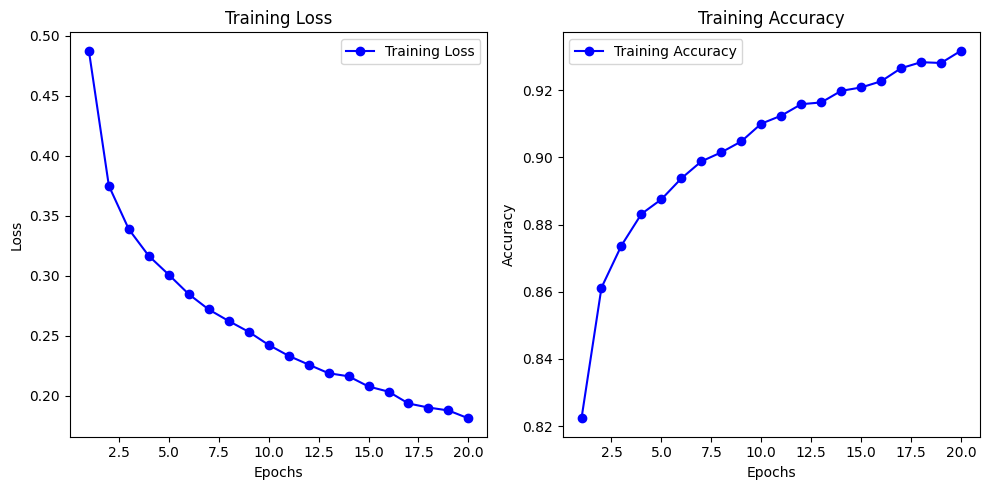

In [51]:
plot_train_results(m1)

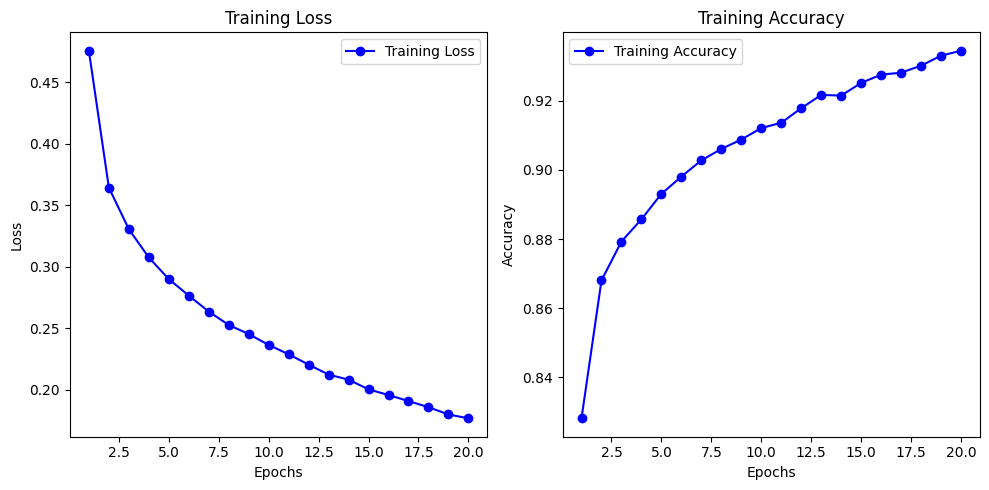

In [50]:
plot_train_results(m2)

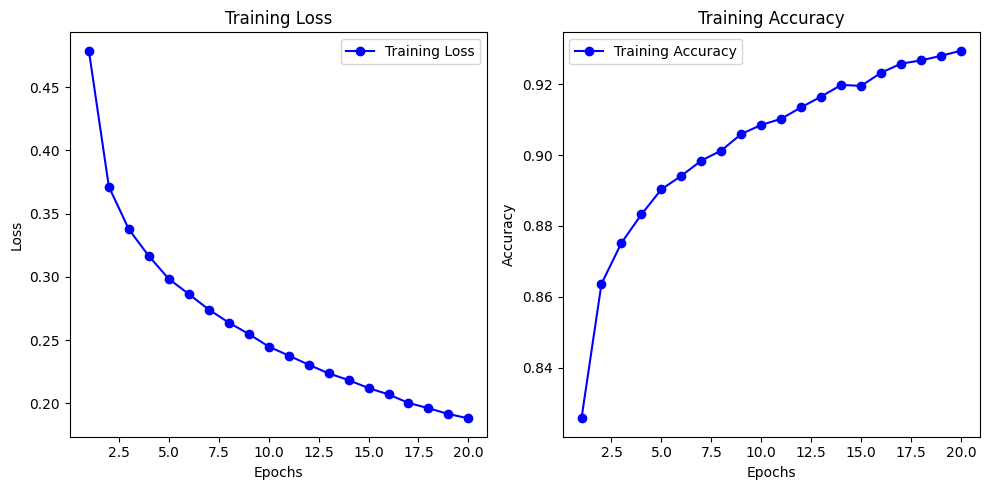

In [49]:
plot_train_results(m3)

## Analysis of Different Hyperparameters

In [64]:
def accuracy_on(labels, outputs, title):
    acc = accuracy_score(labels, outputs)
    return [title, acc]

def format(accuracy): 
    return f"{accuracy:.3f}"

def log_accuracy(model, x_train, x_test, y_train, y_test):
    y_train_pred = model.predict_on(x_train)
    y_test_pred = model.predict_on(x_test)
    table = [
        ['Train', format(model.train_acc_hist[-1])],
        # accuracy_on(y_train, y_train_pred, 'Train'),
        accuracy_on(y_test, y_test_pred, 'Test')
    ]
    print(tabulate(table, headers=["Dataset", "Accuracy"], tablefmt="pretty"))

def plot_curve(data, title: str, y_label: str):
    scale_x = range(1, len(data) + 1)

    plt.figure(figsize=(10, 4))
    plt.plot(scale_x, data)
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [65]:
class Model(nn.Module):
    def __init__(self, h1, do_rate=0, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        # x = self.flatten(x)
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [66]:
class MLP():
    def __init__(self, model, criteria, lambda_reg=0, learning_rate=0.001):
        self.model = model
        self.criteria = criteria
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.optimizer = None 
        self.train_losses, self.train_accuracies = [], []

    def forward(self, images, labels):
        # Forward pass
        outputs = self.model(images)
        loss = self.criteria(outputs, labels)
        return outputs, loss

    def apply_l2_regularization(self):
        l2_reg = 0
        for param in self.model.parameters():
            l2_reg += torch.sum(param ** 2)
        return self.lambda_reg * l2_reg

    def evaluate(self, loader):
        self.model.to(device)
        self.model.eval()
        self.all_preds = []
        self.all_labels = []
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs, loss = self.forward(images, labels)
                loss += self.apply_l2_regularization()

                running_loss += loss.item() * images.size(0)  # is the batch size
                _, predicted = torch.max(outputs, dim=1)
                self.all_preds.extend(predicted.cpu().detach().numpy())
                self.all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(self.all_labels, self.all_preds)

    def train_with_optimizer(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # Reset gradients
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc
    
    def train(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc

    def test(self, loader):
        return self.evaluate(loader)
    
    def compile(self, optimizer, train_loader, test_loader, num_epochs):
        self.optimizer = optimizer(self.model.parameters(), self.learning_rate) # optim.SGD(self.model.parameters(), lr=self.learning_rate)
        train_hist, test_hist = [], []
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_with_optimizer(train_loader)
            train_hist.append({"epoch": epoch, "train_loss": train_loss, "train_acc": train_acc})

        test_loss, test_acc = self.evaluate(test_loader)
        test_hist.append({"test_loss": test_loss, "test_acc": test_acc})
        return train_hist, test_hist
    
    def fit(self, train_loader, test_loader, num_epochs):
        for _ in range(num_epochs):
            train_loss, train_acc = self.train(train_loader)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)

        return self.evaluate(test_loader)


In [67]:
dropout_rates = [0.2, 0.4, 0.8]
learning_rates = [0.001, 0.01, 0.1]
lambda_regs = [0.0001, 0.001, 0.01]
hidden_layer_neuron_counts = [32, 64, 128]


In [68]:
h1= 128
results = {}
table = []

test_loss, test_acc = 0, 0
for do_rate in dropout_rates:
    mlp = MLP(Model(h1, do_rate=do_rate), nn.CrossEntropyLoss())
    test_loss, test_acc = mlp.fit(train_loader, test_loader, num_epochs=20)
    table += [
        [f'Train-{do_rate}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{do_rate}', format(test_acc), format(test_loss)]
    ]
    results[do_rate] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }

In [69]:
print(tabulate(table, headers=["Dropout Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

+------------------+----------+-------+
| Dropout Analysis | Accuracy | Loss  |
+------------------+----------+-------+
|    Train-0.2     |  0.839   | 0.459 |
|     Test-0.2     |  0.832   | 0.464 |
|    Train-0.4     |  0.828   | 0.484 |
|     Test-0.4     |  0.829   | 0.469 |
|    Train-0.8     |  0.776   | 0.643 |
|     Test-0.8     |  0.816   | 0.505 |
+------------------+----------+-------+


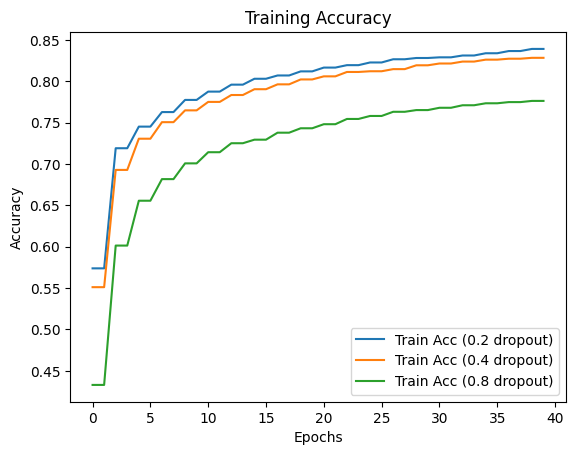

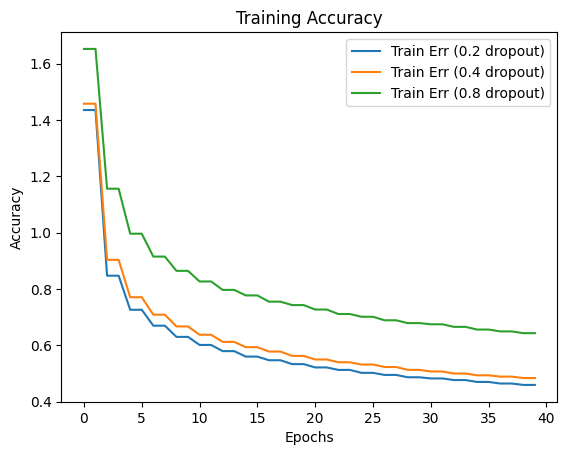

In [70]:
# Plot training and validation accuracy for each optimizer
for metric, history in results.items():
    train_acc = history['train_accuracy']
    plt.plot(train_acc, label=f'Train Acc ({metric} dropout)')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

for metric, history in results.items():
    train_loss = history['train_loss']
    plt.plot(train_loss, label=f'Train Err ({metric} dropout)')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<!-- - [Ref1]()
- [Ref2]()
- [Ref3]() -->

<!--  -->